In [308]:
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
from random import shuffle
from Bio.Align.Applications import MuscleCommandline
from Bio import AlignIO
from include import *
import itertools
import operator
import time

In [309]:
# Read data
orig_seqs = file_to_list("data/File2_ODNA.txt")
filename = "data/I18_S3_R1_001.fastq"
seqs = fastq_to_list(filename)

In [310]:
print("all sequences: ", len(seqs))
print("all orig sequences: ", len(orig_seqs))
seqs = [seq for seq in seqs if len(seq) >= 55 and len(seq)<=65]
print("all long sequences: ",  len(seqs))

all sequences:  100706815
all orig sequences:  49149
all long sequences:  24395990


## Generating 100 clusters from ground truth
First, I took 100 original sequences randomly. Afterward, by performing an exhaustive search, I found corresponding reads to each original sequence with edit distance less than 15. Here, the edit distance is defined as the number of mismatches between two sequences after alignment. Pairwise2 was employed for pairwise alignment which is a fast, yet inaccurate function.

In [337]:
from Bio import pairwise2
#inds = np.random.permutation(len(orig_seqs))
#orig_100 = []
#for ind in inds:
#    orig_100 += [orig_seqs[ind]]
#    if len(orig_100) == 100:
#        break
#true_clusters_100 = []

def edit_dist(u,v):
    ma = pairwise2.align.globalxx(u,v,one_alignment_only=1)
    #ma = multiple_alignment([u,v])
    ctr = 0
    for i in range(min(60,len(ma[0][0]))):
        if ma[0][0][i] != ma[0][1][i]:
        #if ma[0][i] != ma[1][i]:
            ctr += 1
            if ctr>14:
                break
    return ctr

s = time.time()
for i,orig in enumerate(orig_100[95:]):
    cluster = []
    for j,seq in enumerate(seqs):
        score = edit_dist(orig,seq)
        if j%2000000==0:
            print(i,time.time()-s,"seconds")
            s = time.time()
        if score<15:
        #    cluster += [seqs.index(seq)]
            cluster += [seq]
    true_clusters_100 += [cluster]

0 0.0006692409515380859 seconds
0 565.7147877216339 seconds
0 556.5227952003479 seconds
0 557.064444065094 seconds
0 557.4294304847717 seconds
0 558.9607441425323 seconds
0 558.8691167831421 seconds
0 559.4281477928162 seconds
0 558.7251615524292 seconds
0 560.2360582351685 seconds
0 560.3554947376251 seconds
0 559.8339302539825 seconds
0 561.0124228000641 seconds
1 110.21335673332214 seconds
1 558.6030178070068 seconds
1 564.8010272979736 seconds
1 554.9716050624847 seconds
1 555.9077610969543 seconds
1 556.9964034557343 seconds
1 557.8545970916748 seconds
1 557.4760012626648 seconds
1 556.7035617828369 seconds
1 558.249050617218 seconds
1 558.6878042221069 seconds
1 558.6736702919006 seconds
1 564.4131555557251 seconds
2 112.82946491241455 seconds
2 562.6194400787354 seconds
2 560.2940850257874 seconds
2 568.4868042469025 seconds
2 562.1361165046692 seconds
2 560.5851316452026 seconds
2 559.8854565620422 seconds
2 561.1865077018738 seconds
2 562.0918803215027 seconds
2 559.6603243350

## Filter the clusters using muscle function
As I used pairwise2 for generating clusters, it was neccasry to use an accurate alignment for filtering the clusters. Why not using this accurate function from the beginning? Well, for the sake of computational efficiency, it is way more inefficient to use the muscle function for generating the clusters.

In [339]:
true_clusters = []

def edit_dist(u,v):
    ma = multiple_alignment([u,v])
    ctr = 0
    for i in range(min(60,len(ma[0]))):
        if ma[0][i] != ma[1][i]:
            ctr += 1
            if ctr>14:
                break
    return ctr

s = time.time()
for i,orig in enumerate(orig_100):
    cluster = []
    for j,seq in enumerate(true_clusters_100[i]):
        score = edit_dist(orig,seq)
        #print(score)
        if score<10:
        #    cluster += [seqs.index(seq)]
            cluster += [seq]
    
    if i%10==0:
        print("%",i*100/len(orig_100),time.time()-s,'seconds', len(cluster),len(true_clusters_100[i]))
        s = time.time()
    true_clusters += [cluster]

% 0.0 278.4436593055725 seconds 136 473
% 10.0 1208.5228123664856 seconds 25 200
% 20.0 2358.387526988983 seconds 57 398
% 30.0 2269.0535917282104 seconds 72 291
% 40.0 1191.186399936676 seconds 25 123
% 50.0 1741.4391975402832 seconds 115 371
% 60.0 1592.1921999454498 seconds 26 154
% 70.0 2468.9210839271545 seconds 304 948
% 80.0 2632.8573541641235 seconds 286 882
% 90.0 1366.3398458957672 seconds 15 91


## Ignore clusters with less than 10 reads

In [347]:
ids = []
for i,c in enumerate(true_clusters):
    if len(c)<10:
        ids += [i]
finalTC = [true_clusters[i] for i in range(100) if i not in ids]
finalO = [orig_100[i] for i in range(100) if i not in ids]
print(len(finalTC),len(finalO))

95 95


## Calculate overall error probability per position
For doing so, I aligned each sequence with its corresponding original sequence using muscle function (accurate aignment) and checked whether there's a mismatch for a given position or not. Then summed up the number for each position over each cluster and divided by the cluster size. Finally, I averaged the results over all clusters.

In [348]:
errors_total = dict([(i,0) for i in range(60)])
for i,orig in enumerate(finalO):
    errors = dict([(k,0) for k in range(60)])
    seqset = finalTC[i]
    #seqset = true_clusters_100[i]
    for seq in seqset:
        #ma = pairwise2.align.globalxx(orig,seq,one_alignment_only=1)
        ma = multiple_alignment([orig,seq])
        for j in range(60):
            if ma[0][j] != ma[1][j]:
            #if ma[0][0][j] != ma[0][1][j]:
                errors[j] += 1
    for loc in errors:
        errors_total[loc] += errors[loc]/len(seqset)
    print(i)
for loc in errors_total:
    errors_total[loc] /= len(finalO)
errors_total

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94


{0: 0.26022911074752775,
 1: 0.15320008164787838,
 2: 0.1271619904306796,
 3: 0.1162067488744097,
 4: 0.11071315870296934,
 5: 0.09952928596415087,
 6: 0.09756887652871953,
 7: 0.09489048864514563,
 8: 0.10206579740469761,
 9: 0.09233619107060502,
 10: 0.08927229198772699,
 11: 0.08748498097268269,
 12: 0.09420744090497392,
 13: 0.08397311307447883,
 14: 0.0880904629897223,
 15: 0.08641641356090887,
 16: 0.08892752359573594,
 17: 0.09359747230534689,
 18: 0.08462276250099794,
 19: 0.0838507356614424,
 20: 0.09230321275161443,
 21: 0.09248431400573603,
 22: 0.09598655275864763,
 23: 0.09060895630655977,
 24: 0.08765060781769526,
 25: 0.09044317771223723,
 26: 0.09003378211666575,
 27: 0.08904534042852583,
 28: 0.08670721703432333,
 29: 0.09153561834788856,
 30: 0.08642992869969246,
 31: 0.09114556698169846,
 32: 0.09666293987635312,
 33: 0.09097125157011919,
 34: 0.08492779387031466,
 35: 0.08827084956722256,
 36: 0.0890293064424755,
 37: 0.09732735080351955,
 38: 0.10207732930082039,
 

average = 0.12170008633554596


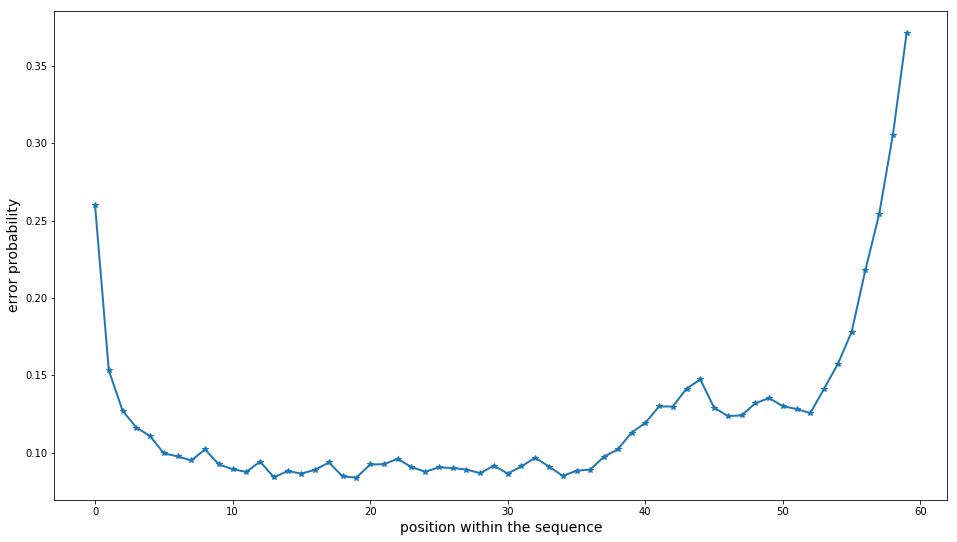

In [349]:
plt.rcParams['figure.figsize'] = (16, 9)
plt.plot(list(errors_total.values())[0:],'*-',linewidth=2)
plt.xlabel('position within the sequence',fontsize=14)
plt.ylabel('error probability',fontsize=14);
#plt.title('')
print('average =',np.mean(list(errors_total.values())[0:]))